In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 00:25:38.411969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 00:25:38.542328: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 00:25:38.545977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 00:25:38.545998: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.json')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in data.items() if count <= 100]
print(f"Number of stations found: {len(no_gaps_tmax)}")


Number of stations found: 103


### Get data, and shape train, validate and test arrays

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
# station -1 gives nice results
station = no_gaps_tmax[50]
print(f"Station selected: {station}")

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into an instance of the Variable class
t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
t_max.convert_time()
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: SP000008202
Filename: SP000008202.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/SP000008202.dly
destination: data/SP000008202.dly
Station details: SP000008202 is SALAMANCA AEROPUERTO, Spain at 40.9592 -5.4981 790.0


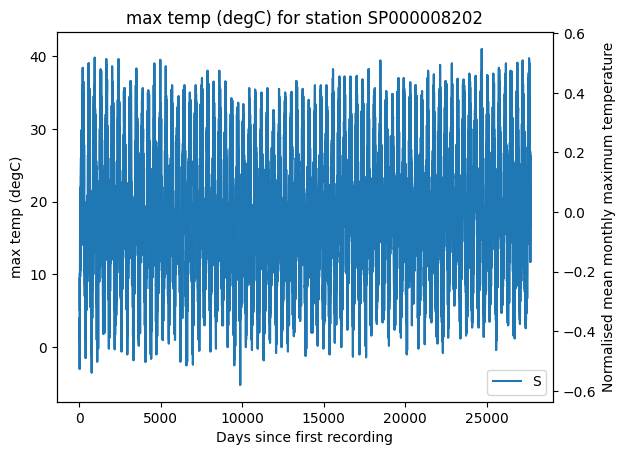

In [4]:
# normalise data
vals_normalised = t_max.normalise(vals)

# plot means and normalised means
fig, ax = plt.subplots()
ax.plot(vals)
ax.set_xlabel("Days since first recording")
ax.set_ylabel(f"{t_max.get_label()}")
ax.set_title(f"{t_max.get_label()} for station {station}")
ax2 = ax.twinx()
ax2.plot(vals_normalised)
ax2.set_ylabel("Normalised mean monthly maximum temperature")
ax.legend(station)


In [5]:
WINDOW_SIZE = 10
OFFSET = 1

# calculate appropriate divisions of data
test_len = int(len(vals_normalised) * 0.2)
train_len = int(len(vals_normalised) * 0.7)
validate_len = int(len(vals_normalised) * 0.1)

print(f"Length of training data: {train_len}")
print(f"Length of validation data: {validate_len}")
print(f"Length of testing data: {test_len}")

# divide data into training, validating and testing sets
vals_test = vals_normalised[:test_len]
vals_train = vals_normalised[test_len+1:test_len+train_len]
vals_validate = vals_normalised[test_len+train_len+1:]

# split data into input windows and targets
input_test, target_test = shapeArray(vals_test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(vals_train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(vals_validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 1
print(f"Training input shape before reshaping: {np.shape(input_train)}")
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(f"Training input shape after reshaping: {np.shape(input_train)}")


Length of training data: 19373
Length of validation data: 2767
Length of testing data: 5535
Training input shape before reshaping: (19362, 10)
Training input shape after reshaping: (19362, 10, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


2023-03-22 00:25:43.344372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 00:25:43.344414: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 00:25:43.344435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 00:25:43.344826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
606/606 [==============================] - 4s 4ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 2/20
606/606 [==============================] - 3s 4ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 3/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 4/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 5/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 6/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 7/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 8/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 9/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 10/20
606/606 [==============================] - 3s 5ms/step - loss: 0.0043 - val_loss: 0.0049

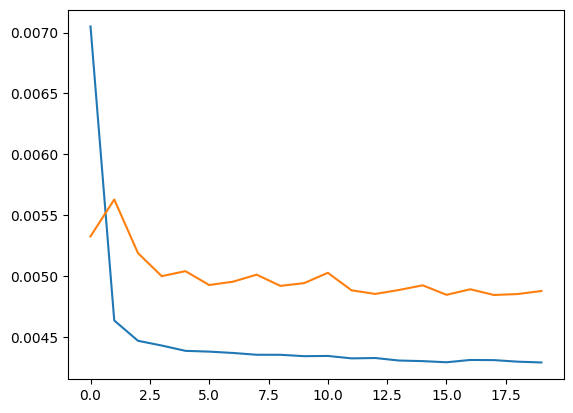

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 1), activation = 'relu', return_sequences = False))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 20, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(cost)
ax.plot(val_cost)

173/173 [==============================] - 1s 3ms/step


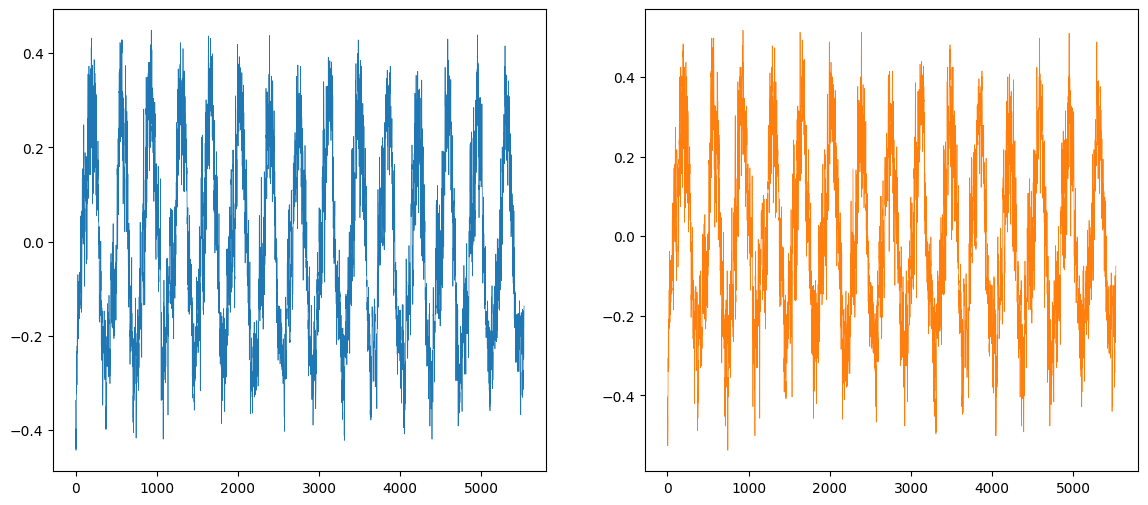

In [7]:
prediction = model.predict(input_test)

fig, ax = plt.subplots(1,2, figsize = (14, 6))
ax[0].plot(prediction, color = 'tab:blue', linewidth = 0.5)
ax[1].plot(target_test, color = 'tab:orange', linewidth = 0.5)


At first glance, these appear to be very similar. Compare the first three months in more detail:

In [11]:
shifted_vals = shift(vals_normalised)

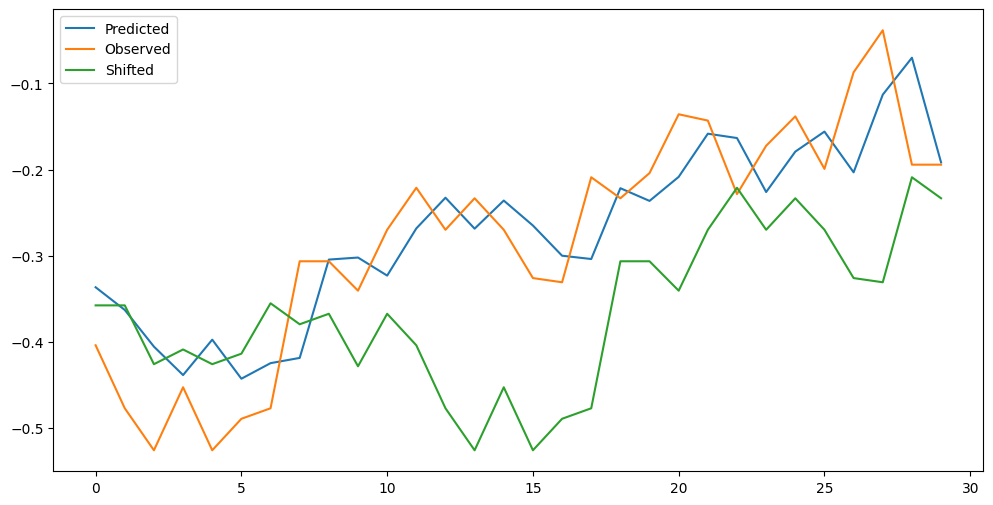

In [14]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(prediction[:30], label = "Predicted", color = 'tab:blue')
ax.plot(target_test[:30], label = "Observed", color = 'tab:orange')
ax.plot(shifted_vals[:30], label = "Shifted", color = 'tab:green')
ax.legend()


In [13]:
print(vals_normalised[:30])
print(shifted_vals[:30])

[-0.35770316 -0.42599584 -0.40892267 -0.42599584 -0.41380072 -0.35526414
 -0.37965438 -0.36745926 -0.42843487 -0.36745926 -0.40404462 -0.47721536
 -0.52599584 -0.45282511 -0.52599584 -0.48941048 -0.47721536 -0.30648365
 -0.30648365 -0.34062999 -0.26989828 -0.2211178  -0.26989828 -0.23331292
 -0.26989828 -0.32599584 -0.33087389 -0.20892267 -0.23331292 -0.20404462]
[-0.35770316 -0.35770316 -0.42599584 -0.40892267 -0.42599584 -0.41380072
 -0.35526414 -0.37965438 -0.36745926 -0.42843487 -0.36745926 -0.40404462
 -0.47721536 -0.52599584 -0.45282511 -0.52599584 -0.48941048 -0.47721536
 -0.30648365 -0.30648365 -0.34062999 -0.26989828 -0.2211178  -0.26989828
 -0.23331292 -0.26989828 -0.32599584 -0.33087389 -0.20892267 -0.23331292]


### Least mean-squared

Sum of the squared errors.

In [9]:
fake_mse = weather_fake_mse(vals)
print(fake_mse)


8.179249168955076
